# Introduction

Sentiment prediction is an interesting task. We will implemement a bi-directional GRU and a bi-directional LSTM neural network to classify a sentence either as positive or negative. Finally, we depoy the model using flask. 

In [71]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers, Input
from tensorflow.keras import losses, optimizers
from tensorflow.keras import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [33]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [89]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 256
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)


test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [90]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(1):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'Example of how a World War 2 documentary should be made,using first hand accounts from actual troops and civilians whom participated in this awful conflict,and archived footage gathered from around the time .I caught this on a re-run on the History channel about a year and a half back,with no knowledge really of the Second World War at the time,but it enveloped me,and now I consider myself a World War 2 buff,watching and reading any and all that I can find about it,but nothing comes close to this landmark documentary,definitely worth buying the boxed set of.............<br /><br />This is quite simply documentary making of the very highest standard.'
Label : 1 (pos)


In [91]:
max_features = 10000
sequence_length = 250

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

embedding_dim = 16

In [92]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

## Bi-directional GRU model

In [101]:
model = tf.keras.Sequential([
  Input(shape=(1,), dtype=tf.string),
  vectorize_layer,
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.Bidirectional(layers.GRU(32, return_sequences=True)),
  layers.Dropout(0.2),
  layers.Bidirectional(layers.GRU(32, return_sequences=True)),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)
])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_6 (TextVe (None, 250)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 250, 16)           160016    
_________________________________________________________________
dropout_22 (Dropout)         (None, 250, 16)           0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 250, 64)           9600      
_________________________________________________________________
dropout_23 (Dropout)         (None, 250, 64)           0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 250, 64)           18816     
_________________________________________________________________
dropout_24 (Dropout)         (None, 250, 64)         

In [102]:
input_data = [["foo qux bar"], ["qux baz"]]

In [103]:
model.predict(input_data)

array([[0.01341667],
       [0.01342541]], dtype=float32)

In [104]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True)

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [105]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs, 
    callbacks=[early_stopping])

Epoch 1/20
79/79 [==============================] - 98s 1s/step - loss: 0.6339 - binary_accuracy: 0.6116 - val_loss: 0.4259 - val_binary_accuracy: 0.8154
Epoch 2/20
79/79 [==============================] - 91s 1s/step - loss: 0.3160 - binary_accuracy: 0.8696 - val_loss: 0.3101 - val_binary_accuracy: 0.8714
Epoch 3/20
79/79 [==============================] - 86s 1s/step - loss: 0.2224 - binary_accuracy: 0.9128 - val_loss: 0.3187 - val_binary_accuracy: 0.8744
Epoch 4/20
79/79 [==============================] - 84s 1s/step - loss: 0.1747 - binary_accuracy: 0.9366 - val_loss: 0.4060 - val_binary_accuracy: 0.8724
Epoch 5/20
79/79 [==============================] - 84s 1s/step - loss: 0.1476 - binary_accuracy: 0.9498 - val_loss: 0.4104 - val_binary_accuracy: 0.8682
Epoch 6/20
79/79 [==============================] - 96s 1s/step - loss: 0.1592 - binary_accuracy: 0.9430 - val_loss: 0.4308 - val_binary_accuracy: 0.8714
Epoch 7/20
79/79 [==============================] - 85s 1s/step - loss: 0.15

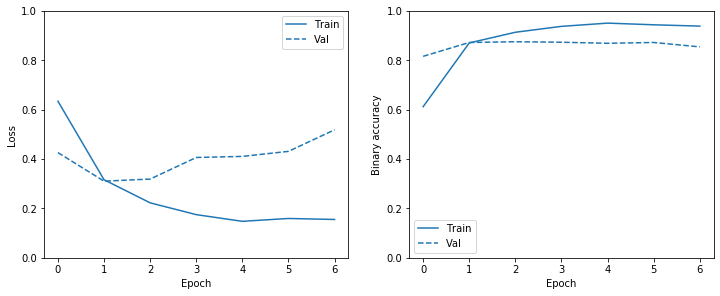

In [108]:
plt.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'binary_accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, 1])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    
plot_metrics(history)

In [119]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

98/98 [==============================] - 28s 283ms/step - loss: 0.3301 - binary_accuracy: 0.8637
Loss:  0.3301178812980652
Accuracy:  0.8636800050735474


## Bi-directional LSTM model

In [113]:
model_LSTM = tf.keras.Sequential([
  Input(shape=(1,), dtype=tf.string),
  vectorize_layer,
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),    
  layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
  layers.Dropout(0.2),
  layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)
])

model_LSTM.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_6 (TextVe (None, 250)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 250, 16)           160016    
_________________________________________________________________
dropout_30 (Dropout)         (None, 250, 16)           0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 250, 64)           12544     
_________________________________________________________________
dropout_31 (Dropout)         (None, 250, 64)           0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 250, 64)           24832     
_________________________________________________________________
dropout_32 (Dropout)         (None, 250, 64)         

In [114]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=3,
    mode='min',
    restore_best_weights=True)

model_LSTM.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizers.Adam(),
              metrics=tf.metrics.BinaryAccuracy())

In [115]:
epochs = 20
history_LSTM = model_LSTM.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs, 
    callbacks=[early_stopping])

Epoch 1/20
79/79 [==============================] - 126s 2s/step - loss: 0.5882 - binary_accuracy: 0.6268 - val_loss: 0.3817 - val_binary_accuracy: 0.8418
Epoch 2/20
79/79 [==============================] - 95s 1s/step - loss: 0.2963 - binary_accuracy: 0.8766 - val_loss: 0.3056 - val_binary_accuracy: 0.8702
Epoch 3/20
79/79 [==============================] - 87s 1s/step - loss: 0.2257 - binary_accuracy: 0.9134 - val_loss: 0.3278 - val_binary_accuracy: 0.8706
Epoch 4/20
79/79 [==============================] - 84s 1s/step - loss: 0.2043 - binary_accuracy: 0.9227 - val_loss: 0.3828 - val_binary_accuracy: 0.8690
Epoch 5/20
79/79 [==============================] - 93s 1s/step - loss: 0.1781 - binary_accuracy: 0.9374 - val_loss: 0.4397 - val_binary_accuracy: 0.8526
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping


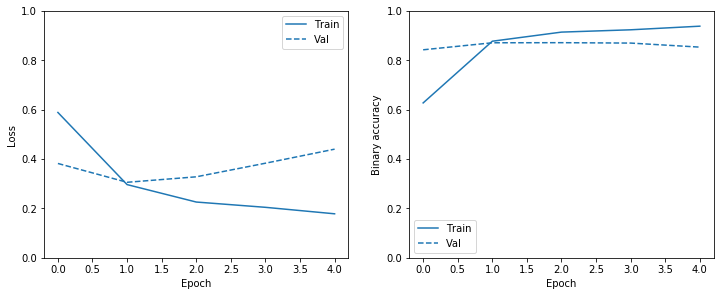

In [116]:
plot_metrics(history_LSTM)

In [117]:
loss, accuracy = model_LSTM.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

98/98 [==============================] - 34s 352ms/step - loss: 0.3242 - binary_accuracy: 0.8624
Loss:  0.3241698741912842
Accuracy:  0.8623999953269958


# Model evaluation to predict

In [155]:
examples = [
  "Best Movie I Have Seen In At Least 10 Years, Should Be Seen Twice", 
  "AN EPIC SAGA OF LOVE & THRILL",
  "To be honest, I did not find the movie as good enough",
  "The movie was terrible..."
]

predictions = model.predict(examples)

In [156]:
print("-- More readable --")
for i in range(len(examples)):
    comment = examples[i]
    score = predictions[i][0]
    review = "So-so"
    if score < -0.40:
        review = "Very negative review"
    elif score < -0.20:
        review = "Negative review"
    elif score > 0.0:
        review = "Positive review"
    print("{} => {} : {}".format(comment, score, review))
print("-------------------")

-- More readable --
Best Movie I Have Seen In At Least 10 Years, Should Be Seen Twice => 0.15448525547981262 : Positive review
AN EPIC SAGA OF LOVE & THRILL => 0.014763645827770233 : Positive review
To be honest, I did not find the movie as good enough => -0.26543083786964417 : Negative review
The movie was terrible... => -1.2031275033950806 : Very negative review
-------------------
